# 🎓 **Maestría en Inteligencia Artificial Aplicada**

## 📈 **Curso: Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular:** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente:** Verónica Sandra Guzmán de Valle

### 📊 **Actividad 4 | Métricas de calidad de resultados**

#### 📅 **6 de junio de 2025**

🧑‍💻 **A01016093:** Oscar Enrique García García 

# 0.1. Importar librerías

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, count, when, isnan, desc, lit, concat
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import RFormula
import warnings
warnings.filterwarnings('ignore')

# 0.2. Crear sesión de spark y leer archivo

In [2]:
spark = SparkSession.builder \
    .appName("Actividad4_MetricasCalidad") \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 

25/06/06 21:52:47 WARN Utils: Your hostname, MacBook-Air-de-Oscar-2.local resolves to a loopback address: 127.0.0.1; using 192.168.68.103 instead (on interface en0)
25/06/06 21:52:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/06 21:52:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("/Users/oscgarcia/Documents/MNA/Análisis de Grandes Volúmenes de Datos/US_Accidents_Dec19.csv", header=True, inferSchema=True)
df.show(5)

25/06/06 21:52:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/06/06 21:53:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [4]:
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 7728394
Número de columnas: 46


# 0.3. Selección de columnas

In [5]:
cols_to_select = ["Temperature(F)","Weather_Condition","Severity",
               "Humidity(%)", "Pressure(in)", "Wind_Direction",
               "Wind_Speed(mph)","Precipitation(in)"] #Se definen las columnas a mantener.

df = df.select(cols_to_select) #Se seleccionan únicamente las columnas definidas en el paso anterior.
df.show()

+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|          36.9|       Light Rain|       3|       91.0|       29.68|          Calm|           NULL|             0.02|
|          37.9|       Light Rain|       2|      100.0|       29.65|          Calm|           NULL|              0.0|
|          36.0|         Overcast|       2|      100.0|       29.67|            SW|            3.5|             NULL|
|          35.1|    Mostly Cloudy|       3|       96.0|       29.64|            SW|            4.6|             NULL|
|          36.0|    Mostly Cloudy|       2|       89.0|       29.65|            SW|            3.5|             NULL|
|          37.9|       Light Rain|       3|       97.0| 

In [6]:
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 7728394
Número de columnas: 8


In [7]:
df.describe()

summary,Temperature(F),Weather_Condition,Severity,Humidity(%),Pressure(in),Wind_Direction,Wind_Speed(mph),Precipitation(in)
count,7564541,7554935,7728394,7554250,7587715,7553188,7157161,5524808
mean,61.66328580940991,NULL,2.212384487643875,64.83104146672403,29.538985607656194,NULL,7.685489595665597,0.008407209807109432
stddev,19.013653291093142,NULL,0.4875313339360398,22.820967660113475,1.00618980914562,NULL,5.424983437161068,0.11022464885795538
min,-89.0,Blowing Dust,1,1.0,0.0,CALM,0.0,0.0
max,207.0,Wintry Mix / Windy,4,100.0,58.63,West,1087.0,36.47


In [8]:
df.printSchema()

root
 |-- Temperature(F): double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)



# 1. Construcción de la muestra M

In [9]:
reglas_particionamiento = [
    {"Weather_Condition": "Fair", "Severity": 2},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 2},
    {"Weather_Condition": "Cloudy", "Severity": 2},
    {"Weather_Condition": "Partly Cloudy", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 2},
    {"Weather_Condition": "Light Rain", "Severity": 2},
    {"Weather_Condition": "Overcast", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 3},
    {"Weather_Condition": "Fair", "Severity": 3},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 3},
] #Se enlistan las particiones elegidas en el documento del proyecto.

muestras = [] #Se crea una lista vacía, que guardará las muestras.
tamaño_muestra_por_particion = 10000 #Se define el tamaño de la muestra (para cada partición).

for regla in reglas_particionamiento: #Se recorre la lista de reglas de particionamiento.
    condicion_clima = regla["Weather_Condition"]
    severidad = regla["Severity"]

    df_filtrado = df.filter(
        (col("Weather_Condition") == condicion_clima) &
        (col("Severity") == severidad)
    ).limit(tamaño_muestra_por_particion) #Se filtran los primeros n registros (tamaño de la muestra), que cumpla con las condiciones estipuladas en las reglas de particionamiento.

    muestras.append(df_filtrado) #Se agregan los datos a la lista de muestras

df_muestra_M = muestras[0]
for df_temp in muestras[1:]:
    df_muestra_M = df_muestra_M.union(df_temp) #Se unen todas las muestras en un solo dataframe.

df_muestra_M.show(5)


+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|          87.0|             Fair|       2|       35.0|       29.11|           SSE|            8.0|              0.0|
|          94.0|             Fair|       2|       31.0|       29.08|           SSE|            9.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
+--------------+-----------------+--------+-----------+-

<Figure size 1000x500 with 0 Axes>

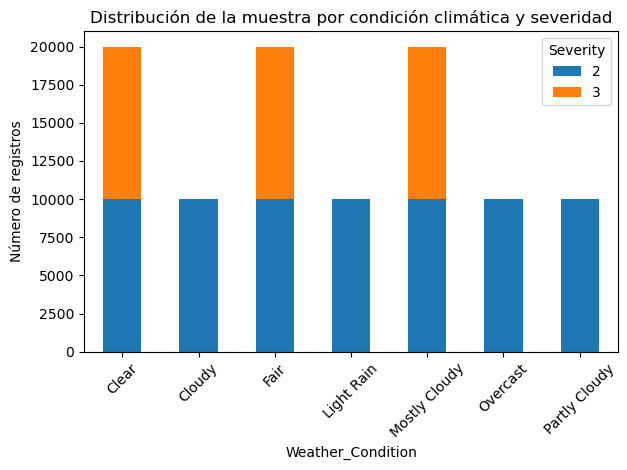

In [10]:
muestra_pd = df_muestra_M.select("Severity", "Weather_Condition").toPandas()
plt.figure(figsize=(10, 5))
muestra_pd.groupby(["Weather_Condition", "Severity"]).size().unstack().plot(kind='bar', stacked=True)
plt.title("Distribución de la muestra por condición climática y severidad")
plt.ylabel("Número de registros")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.1. Preparación de los datos

A continuación, se definen estrategias de imputación de valores nulos, dependiendo del tipo de dato de cada una de las columnas.

Para las variables numéricas, se optó por imputar la mediana; mientras que para las variables categóricas (en este caso es una sola: Wind Direction), se optó por imputar la moda.

In [11]:
cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Precipitation(in)","Wind_Speed(mph)"] #Se definen las columnas a las que se les aplicará la transformación
imputed_cols = [f"{c}_imputed" for c in cols] #Se definen los nombres de las columnas a las que se les aplicará la transformación (imputar la media en valores nulos).

imputer = Imputer(
    inputCols=cols,
    outputCols=imputed_cols
).setStrategy("median") #Se definen las columnas a las que se les aplicará la transformación

df_imputed = imputer.fit(df_muestra_M).transform(df_muestra_M) #Se aplica la transformación (imputar la media en valores nulos) a las columnas previamente definidas.

for orig, imp in zip(cols, imputed_cols):
    df_imputed = df_imputed.drop(orig).withColumnRenamed(imp, orig)


In [12]:
# Calcular la moda de 'Wind_Direction'
mode_wind_dir = df_imputed.groupBy("Wind_Direction").count().orderBy(desc("count")).first()[0]

# Reemplazar valores nulos en 'Wind_Direction' con la moda
df_imputed = df_imputed.fillna({"Wind_Direction": mode_wind_dir})


Una vez aplicadas las transformaciones anteriores, se procede con los siguientes pasos:

1. Convertir las variables categóricas a valores numéricos, por medio de StringIndexer, con el fin de que los modelos puedan trabajar únicamente con variables numéricas.

2. Se juntan todas las variables en una columna tipo "Vector", por medio de VectorAssembler, en una columna "features", con el fin de que los modelos trabajen directamente con esta columna.

3. Se construye el dataframe df_procesado, con el resultado de las transformaciones anteriores.

In [13]:
df_imputed.count() #Se verifica que existan 140,000 registros, que es el resultado de multiplicar el tamaño de la muestra (10,000) por el número de particiones (10).

100000

In [14]:
#Checar si hay valores nulos
df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imputed.columns]).show() #Se verifica que no existan valores nulos en el dataframe resultante.

+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+
|Weather_Condition|Severity|Wind_Direction|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+
|                0|       0|             0|             0|          0|           0|                0|              0|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+



In [15]:
# Convertimos columnas categóricas a numéricas
indexers = [StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_idx"),
            StringIndexer(inputCol="Wind_Direction", outputCol="Wind_Direction_idx")
            ]

for indexer in indexers:
    df_imputed = indexer.fit(df_imputed).transform(df_imputed)

# Armamos el vector de características.
rForm = RFormula(formula="Severity ~ .")
fittedRF = rForm.fit(df_imputed)
df_preprocesado = fittedRF.transform(df_imputed)

df_preprocesado.show(5)


+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+
|Weather_Condition|Severity|Wind_Direction|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+
|             Fair|       2|           SSE|          87.0|       35.0|       29.11|              0.0|            8.0|                  1.0|               8.0|(36,[1,14,29,30,3...|  2.0|
|             Fair|       2|           SSE|          94.0|       31.0|       29.08|              0.0|            9.0|                  1.0|               8.0|(36,[1,14,29,30,3...|  2.0|
|             Fair|       2|             S|          85.0|       44.0|

# 1.2 Manejo de outliers

A continuación se definen las funciones que nos ayudarán a calcular el IQR para las variables numéricas y, en caso de existir outliers, se sustituirán con la mediana.

In [16]:
def calcular_limites_iqr(df, columna):
    quantiles = df.approxQuantile(columna, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

In [17]:
def imputar_outliers_con_mediana(df, columna):
    # Calcular límites
    lower, upper = calcular_limites_iqr(df, columna)

    # Calcular mediana
    mediana = df.approxQuantile(columna, [0.5], 0.01)[0]

    # Crear nueva columna imputada
    nueva_columna = f"{columna}_sin_outliers"
    df = df.withColumn(nueva_columna, 
        when((col(columna) < lower) | (col(columna) > upper), lit(mediana))
        .otherwise(col(columna))
    )

    return df


In [18]:
columnas_a_tratar = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Precipitation(in)", "Wind_Speed(mph)"]

for col_name in columnas_a_tratar:
    df_preprocesado = imputar_outliers_con_mediana(df_preprocesado, col_name)

# 2. Construcción Train - Test

In [19]:
# Caso 1
# Construcción de un train - test con 200 ejecutores por default
spark.conf.set("spark.sql.shuffle.partitions", "200")
train_data_rand_200w_a,test_data_rand_200w_a = df_preprocesado.randomSplit([0.7,0.3], seed = 42)
print(f"""Existen {train_data_rand_200w_a.count()} instancias en el conjunto train, y {test_data_rand_200w_a.count()} en el conjunto test""")

Existen 70222 instancias en el conjunto train, y 29778 en el conjunto test


In [20]:
# Construcción de un train - test con 1 ejecutor
spark.conf.set("spark.sql.shuffle.partitions", "1")
train_data_rand_1w_a,test_data_rand_1w_a = df_preprocesado.randomSplit([0.7,0.3], seed = 42)
print(f"""Existen {train_data_rand_1w_a.count()} instancias en el conjunto train, y {test_data_rand_1w_a.count()} en el conjunto test""")

Existen 70222 instancias en el conjunto train, y 29778 en el conjunto test


In [21]:

preparedDF_a_stratum = df_preprocesado.withColumn("stratum", concat(df_preprocesado["Weather_Condition"], lit("_"), df_preprocesado["Severity"]))
preparedDF_a_stratum.show(5)

+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|Weather_Condition|Severity|Wind_Direction|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|Temperature(F)_sin_outliers|Humidity(%)_sin_outliers|Pressure(in)_sin_outliers|Precipitation(in)_sin_outliers|Wind_Speed(mph)_sin_outliers|stratum|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|

In [22]:
preparedDF_a_stratum.printSchema()

root
 |-- Weather_Condition: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Wind_Direction: string (nullable = false)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Weather_Condition_idx: double (nullable = false)
 |-- Wind_Direction_idx: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- Temperature(F)_sin_outliers: double (nullable = true)
 |-- Humidity(%)_sin_outliers: double (nullable = true)
 |-- Pressure(in)_sin_outliers: double (nullable = true)
 |-- Precipitation(in)_sin_outliers: double (nullable = true)
 |-- Wind_Speed(mph)_sin_outliers: double (nullable = true)
 |-- stratum: string (nullable = true)



In [23]:
# Se calcula la cantidad de instancias por cada valor diferente de las variables Weather_Condition, Severity y combinada
stratum_counts_weather_c = preparedDF_a_stratum.groupBy("Weather_Condition").count().collect()
stratum_counts_severity = preparedDF_a_stratum.groupBy("Severity").count().collect()
stratum_counts_combined_a = preparedDF_a_stratum.groupBy("Weather_Condition", "Severity").count().collect()
stratum_counts_combined = preparedDF_a_stratum.groupBy("stratum").count().collect()

print(stratum_counts_weather_c)
print(stratum_counts_severity)
print(stratum_counts_combined_a)
print(stratum_counts_combined)


[Row(Weather_Condition='Fair', count=20000), Row(Weather_Condition='Mostly Cloudy', count=20000), Row(Weather_Condition='Cloudy', count=10000), Row(Weather_Condition='Partly Cloudy', count=10000), Row(Weather_Condition='Clear', count=20000), Row(Weather_Condition='Light Rain', count=10000), Row(Weather_Condition='Overcast', count=10000)]
[Row(Severity=2, count=70000), Row(Severity=3, count=30000)]
[Row(Weather_Condition='Fair', Severity=2, count=10000), Row(Weather_Condition='Mostly Cloudy', Severity=2, count=10000), Row(Weather_Condition='Cloudy', Severity=2, count=10000), Row(Weather_Condition='Partly Cloudy', Severity=2, count=10000), Row(Weather_Condition='Clear', Severity=2, count=10000), Row(Weather_Condition='Light Rain', Severity=2, count=10000), Row(Weather_Condition='Overcast', Severity=2, count=10000), Row(Weather_Condition='Clear', Severity=3, count=10000), Row(Weather_Condition='Fair', Severity=3, count=10000), Row(Weather_Condition='Mostly Cloudy', Severity=3, count=10000

In [24]:
# MUESTREO ESTRATIFICADO A PARTIR DE LA UNION DE PARTICIONES

#se inicializa train_data_stratum y test_data_stratum como dataframes vacios
train_data_stratum_parts = []
test_data_stratum_parts = []

for row in stratum_counts_combined:
  stratum = row['stratum']
  # se extraen todos los registros con el valor de stratum
  stratum_df = preparedDF_a_stratum.filter(preparedDF_a_stratum.stratum == stratum)
  # Se genera la particion 70 - 30 deseada
  train_data_stratified, test_data_stratified = stratum_df.randomSplit([0.7, 0.3], seed=42)
  # Se unen los conjuntos
  train_data_stratum_parts.append(train_data_stratified)
  test_data_stratum_parts.append(test_data_stratified)



In [25]:
#from pyspark.sql.functions import col
if train_data_stratum_parts:
    # Use the first DataFrame as the base and union the rest
    train_data_stratum_b = train_data_stratum_parts[0]
    for i in range(1, len(train_data_stratum_parts)):
        train_data_stratum_b = train_data_stratum_b.unionAll(train_data_stratum_parts[i])
if test_data_stratum_parts:
    # Use the first DataFrame as the base and union the rest
    test_data_stratum_b = test_data_stratum_parts[0]
    for i in range(1, len(test_data_stratum_parts)):
        test_data_stratum_b = test_data_stratum_b.unionAll(test_data_stratum_parts[i])

print(f"""Existen {train_data_stratum_b.count()} instancias en el conjunto train, y {test_data_stratum_b.count()} en el conjunto test""")

train_data_stratum_b.show(5)
test_data_stratum_b.show(5)

25/06/06 22:07:49 WARN DAGScheduler: Broadcasting large task binary with size 1098.8 KiB
25/06/06 22:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1098.8 KiB


Existen 70222 instancias en el conjunto train, y 29778 en el conjunto test


25/06/06 22:09:08 WARN DAGScheduler: Broadcasting large task binary with size 1209.9 KiB


+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|Weather_Condition|Severity|Wind_Direction|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|Temperature(F)_sin_outliers|Humidity(%)_sin_outliers|Pressure(in)_sin_outliers|Precipitation(in)_sin_outliers|Wind_Speed(mph)_sin_outliers|stratum|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|

+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|Weather_Condition|Severity|Wind_Direction|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|Temperature(F)_sin_outliers|Humidity(%)_sin_outliers|Pressure(in)_sin_outliers|Precipitation(in)_sin_outliers|Wind_Speed(mph)_sin_outliers|stratum|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|

25/06/06 22:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB


# 3. Selección de métricas para medir calidad de resultados

## Justificación de métricas de evaluación

Se seleccionaron las métricas Accuracy, Precision y Recall por las siguientes razones fundamentadas en el análisis previo:

1. Accuracy (Exactitud):
   - El dataset fue estratificado y balanceado por las combinaciones más comunes de Weather_Condition y Severity (niveles 2 y 3).
   - Esto permite utilizar accuracy como una métrica representativa del desempeño general del modelo.

2. Precision (Precisión):
   - Dada la relevancia de evitar falsos positivos en eventos severos, como accidentes durante climas extremos, se requiere una métrica que indique la confiabilidad de las predicciones positivas.
   - Esto es importante para evitar alarmas falsas que puedan sobrecargar recursos de atención o respuesta.

3. Recall (Exhaustividad):
   - En el contexto de seguridad vial, es preferible detectar todos los accidentes severos aunque se cometan algunos falsos positivos.
   - El recall es crucial para evaluar qué tan bien el modelo identifica todos los casos graves.

Estas métricas reflejan el compromiso entre detectar la mayor cantidad de eventos severos y evitar clasificaciones incorrectas, lo cual es clave en aplicaciones reales de análisis de siniestros viales.


# 4. Entrenamiento de Modelos de Aprendizaje

In [26]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20, maxDepth=6)

In [27]:
rfModel_a = rf.fit(train_data_rand_200w_a)
rfModel_b = rf.fit(train_data_rand_1w_a)
rfModel_d = rf.fit(train_data_stratum_b)

25/06/06 22:15:56 WARN DAGScheduler: Broadcasting large task binary with size 1109.5 KiB
25/06/06 22:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB
25/06/06 22:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB
25/06/06 22:16:33 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
25/06/06 22:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1334.9 KiB
25/06/06 22:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1343.4 KiB
25/06/06 22:16:38 WARN DAGScheduler: Broadcasting large task binary with size 1356.0 KiB
25/06/06 22:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1378.0 KiB
25/06/06 22:16:40 WARN DAGScheduler: Broadcasting large task binary with size 1413.4 KiB
25/06/06 22:16:42 WARN DAGScheduler: Broadcasting large task binary with size 1470.8 KiB


In [28]:
# Imprimiendo los valores de predicción del modelo sobre el train
rfModel_a.transform(train_data_rand_200w_a).select('Severity', 'label', 'rawPrediction', 'prediction', 'probability').show(5)
rfModel_b.transform(train_data_rand_1w_a).select('Severity', 'label', 'rawPrediction', 'prediction', 'probability').show(5)
rfModel_d.transform(train_data_stratum_b).select('Severity', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+--------+-----+--------------------+----------+--------------------+
|Severity|label|       rawPrediction|prediction|         probability|
+--------+-----+--------------------+----------+--------------------+
|       2|  2.0|[0.0,0.0,11.44713...|       2.0|[0.0,0.0,0.572356...|
|       2|  2.0|[0.0,0.0,11.44713...|       2.0|[0.0,0.0,0.572356...|
|       2|  2.0|[0.0,0.0,11.44713...|       2.0|[0.0,0.0,0.572356...|
|       2|  2.0|[0.0,0.0,11.55860...|       2.0|[0.0,0.0,0.577930...|
|       2|  2.0|[0.0,0.0,11.10637...|       2.0|[0.0,0.0,0.555318...|
+--------+-----+--------------------+----------+--------------------+
only showing top 5 rows



+--------+-----+--------------------+----------+--------------------+
|Severity|label|       rawPrediction|prediction|         probability|
+--------+-----+--------------------+----------+--------------------+
|       2|  2.0|[0.0,0.0,11.44713...|       2.0|[0.0,0.0,0.572356...|
|       2|  2.0|[0.0,0.0,11.44713...|       2.0|[0.0,0.0,0.572356...|
|       2|  2.0|[0.0,0.0,11.44713...|       2.0|[0.0,0.0,0.572356...|
|       2|  2.0|[0.0,0.0,11.55860...|       2.0|[0.0,0.0,0.577930...|
|       2|  2.0|[0.0,0.0,11.10637...|       2.0|[0.0,0.0,0.555318...|
+--------+-----+--------------------+----------+--------------------+
only showing top 5 rows



+--------+-----+--------------------+----------+--------------------+
|Severity|label|       rawPrediction|prediction|         probability|
+--------+-----+--------------------+----------+--------------------+
|       2|  2.0|[0.0,0.0,11.57088...|       2.0|[0.0,0.0,0.578544...|
|       2|  2.0|[0.0,0.0,11.57088...|       2.0|[0.0,0.0,0.578544...|
|       2|  2.0|[0.0,0.0,11.57088...|       2.0|[0.0,0.0,0.578544...|
|       2|  2.0|[0.0,0.0,11.40509...|       2.0|[0.0,0.0,0.570254...|
|       2|  2.0|[0.0,0.0,11.57088...|       2.0|[0.0,0.0,0.578544...|
+--------+-----+--------------------+----------+--------------------+
only showing top 5 rows



25/06/06 22:18:58 WARN DAGScheduler: Broadcasting large task binary with size 1420.5 KiB


In [29]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_a = evaluator.evaluate(rfModel_a.transform(test_data_rand_200w_a))
accuracy_b = evaluator.evaluate(rfModel_b.transform(test_data_rand_1w_a))
accuracy_d = evaluator.evaluate(rfModel_d.transform(test_data_stratum_b))

# Imprimiendo cada resultado de accuracy
print("Accuracy for train_data_rand_200w_a: %.3f" % accuracy_a)
print("Accuracy for train_data_rand_1w_a: %.3f" % accuracy_b)
print("Accuracy for train_data_stratum_b: %.3f" % accuracy_d)

25/06/06 22:20:39 WARN DAGScheduler: Broadcasting large task binary with size 1433.9 KiB


Accuracy for train_data_rand_200w_a: 0.718
Accuracy for train_data_rand_1w_a: 0.718
Accuracy for train_data_stratum_b: 0.711


In [30]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

prec_a = precision_evaluator.evaluate(rfModel_a.transform(test_data_rand_200w_a))
prec_b = precision_evaluator.evaluate(rfModel_b.transform(test_data_rand_1w_a))
prec_d = precision_evaluator.evaluate(rfModel_d.transform(test_data_stratum_b))

# Imprimiendo cada resultado de accuracy
print("Precision for train_data_rand_200w_a: %.3f" % prec_a)
print("Precision for train_data_rand_1w_a: %.3f" % prec_b)
print("Precision for train_data_stratum_b: %.3f" % prec_d)

25/06/06 22:22:26 WARN DAGScheduler: Broadcasting large task binary with size 1433.9 KiB


Precision for train_data_rand_200w_a: 0.692
Precision for train_data_rand_1w_a: 0.692
Precision for train_data_stratum_b: 0.696


In [31]:
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

rec_a = recall_evaluator.evaluate(rfModel_a.transform(test_data_rand_200w_a))
rec_b = recall_evaluator.evaluate(rfModel_b.transform(test_data_rand_1w_a))
rec_d = recall_evaluator.evaluate(rfModel_d.transform(test_data_stratum_b))

# Imprimiendo cada resultado de accuracy
print("Recall for train_data_rand_200w_a: %.3f" % rec_a)
print("Recall for train_data_rand_1w_a: %.3f" % rec_b)
print("Recall for train_data_stratum_b: %.3f" % rec_d)

25/06/06 22:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1433.9 KiB


Recall for train_data_rand_200w_a: 0.718
Recall for train_data_rand_1w_a: 0.718
Recall for train_data_stratum_b: 0.711


Accuracy: 0.7110
Precision: 0.6963
Recall: 0.7110


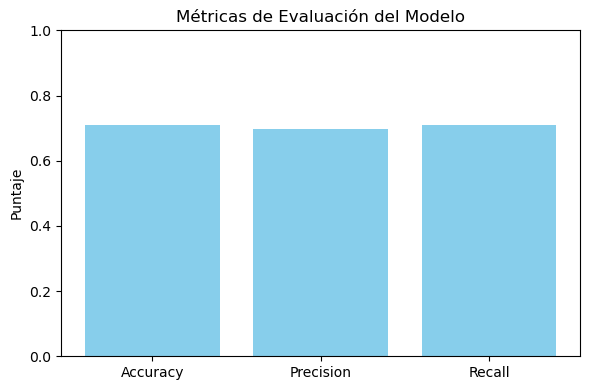

In [32]:
print(f"Accuracy: {accuracy_d:.4f}")
print(f"Precision: {prec_d:.4f}")
print(f"Recall: {rec_d:.4f}")

metricas_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall'],
    'Valor': [accuracy_d, prec_d, rec_d]
})
plt.figure(figsize=(6,4))
plt.bar(metricas_df['Métrica'], metricas_df['Valor'], color='skyblue')
plt.title('Métricas de Evaluación del Modelo')
plt.ylim(0, 1)
plt.ylabel('Puntaje')
plt.tight_layout()
plt.show()

# 5. Análisis de resultados